In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# XGBoost with Mean Encodings of all Hierarchical Levels
Include all levels of encodings.  This is an additional baseline for hierarchical or target-mean encoding.

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_blender
from sba_gnn.sba_gnn.sg_blender import HierarchicalEncoder # Target encoder

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

#### Re-encode the features, with the new threshold

In [7]:
train_df = sba_loans[sba_loans['dset'] == 'train']

In [8]:
naics_features = ['NAICS', 'NAICS_5', 'NAICS_4', 'NAICS_3', 'NAICS_sector']

In [9]:
# Create encoders
enc_dict = {f:HierarchicalEncoder(lambda_k = setup.selected_lambda_k) for f in naics_features}

In [10]:
# fit encoders
[enc_dict[f].fit(train_df[[f]], train_df['target']) for f in naics_features]

[None, None, None, None, None]

In [11]:
with open(Path(setup.temp_path).joinpath('A22_DATA_encoder.pkl'), 'wb') as fout:
    pickle.dump(enc_dict, fout)

In [12]:
# Transform the data
enc_val = pd.concat([enc_dict[f].transform(sba_loans[[f]]) for f in naics_features],
                    axis=1, keys=naics_features)
enc_val.columns = ['menc_' + c for c in enc_val.columns]

In [13]:
enc_val

,menc_NAICS,menc_NAICS_5,menc_NAICS_4,menc_NAICS_3,menc_NAICS_sector
index,,,,,
0,0.229316,0.229316,0.188969,0.195057,0.223429
1,0.141762,0.141762,0.141762,0.240226,0.218456
2,0.040818,0.040818,0.040818,0.089955,0.100917
5,0.064767,0.074627,0.074627,0.110563,0.155853
7,0.138268,0.152833,0.154375,0.169607,0.201483
...,...,...,...,...,...
897159,0.204194,0.198369,0.140757,0.110563,0.155853
897160,0.102536,0.102536,0.167513,0.174326,0.155853
897162,0.229316,0.229316,0.188969,0.195057,0.223429


In [14]:
predictor_features = setup.predictor_features + list(enc_val.columns)
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'menc_NAICS', 'menc_NAICS_5', 'menc_NAICS_4', 'menc_NAICS_3', 'menc_NAICS_sector']


In [15]:
with open(Path(setup.temp_path).joinpath('A22_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

In [16]:
# Save the values
pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']] \
               .drop(columns=enc_val.columns, errors='ignore'), enc_val], axis = 1) \
    .to_parquet(Path(setup.temp_path).joinpath('A22_DATA_encodings.parquet'))

In [17]:
sba_loans = pd.concat([sba_loans.drop(columns=enc_val.columns, errors='ignore'), enc_val], 
                      axis=1)
print(sba_loans.shape)

(688081, 58)


In [18]:
train_df = sba_loans[sba_loans['dset'] == 'train']
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

## Model Fit

In [19]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [20]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [21]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)

In [22]:
xgb_model = xgb_model.set_params(**xgb_params)

In [23]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.50028	validation_1-logloss:0.50380
[1]	validation_0-logloss:0.49268	validation_1-logloss:0.49640
[2]	validation_0-logloss:0.48634	validation_1-logloss:0.49027
[3]	validation_0-logloss:0.48093	validation_1-logloss:0.48506
[4]	validation_0-logloss:0.47639	validation_1-logloss:0.48073
[5]	validation_0-logloss:0.47244	validation_1-logloss:0.47694
[6]	validation_0-logloss:0.46907	validation_1-logloss:0.47374
[7]	validation_0-logloss:0.46617	validation_1-logloss:0.47102
[8]	validation_0-logloss:0.46366	validation_1-logloss:0.46868
[9]	validation_0-logloss:0.46152	validation_1-logloss:0.46669
[10]	validation_0-logloss:0.45964	validation_1-logloss:0.46497
[11]	validation_0-logloss:0.45805	validation_1-logloss:0.46351
[12]	validation_0-logloss:0.45669	validation_1-logloss:0.46228
[13]	validation_0-logloss:0.45546	validation_1-logloss:0.46119
[14]	validation_0-logloss:0.45438	validation_1-logloss:0.46023
[15]	validation_0-logloss:0.45336	validation_1-logloss:0.45932
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [24]:
train_df['target'].value_counts()

target
0    346866
1     89254
Name: count, dtype: int64

##### Save the model

In [25]:
xgb_model.save_model(Path(setup.temp_path).joinpath('A22_MODEL_xgboost.json'))

In [26]:
with open(Path(setup.temp_path).joinpath('A22_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [27]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [28]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.185202,0.114898,0.016034,0.654283,0.170675
1,0.285721,0.110885,0.016213,0.655854,0.289823


## Decision Threshold
Max f1, on training data

In [29]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [30]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [31]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('A22_REPORT_thresh_tune.csv'), index=False)

In [32]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.24


,thresh,f1
12,0.24,0.456874
11,0.22,0.456042


##### Apply decision threshold
All datasets

In [33]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [34]:
pred_df['predict_bin'].value_counts()

predict_bin
0    403606
1    284475
Name: count, dtype: int64

In [35]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A22_DATA_combined_predictions.parquet'))

## Metrics

In [36]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('A22_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.659088,0.442578,0.325538,0.691019,0.375347,0.732629,NaN
1,train,0.664533,0.456874,0.341633,0.689437,0.396379,0.737731,NaN
2,val,0.661245,0.452738,0.340501,0.675348,0.389151,0.728572,NaN
0,test,0.660489,0.452467,0.338532,0.681996,0.387535,0.730731,0.0
1,test,0.657074,0.427883,0.307019,0.705693,0.360323,0.736726,1.0


## Lift
Test data

In [37]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

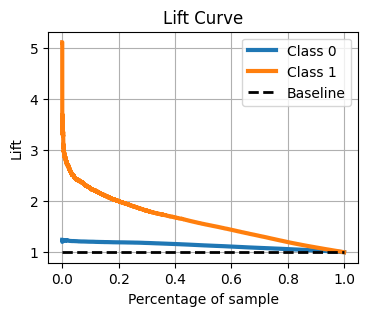

In [38]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('A22_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [39]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [40]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('A22_REPORT_importance_gain.csv'), index=True)

In [41]:
feat_impgain.head()

,importance
urban_flag,348.268738
menc_NAICS,199.709015
LowDoc,143.849396
DisbursementGross,56.190418
menc_NAICS_5,28.418304


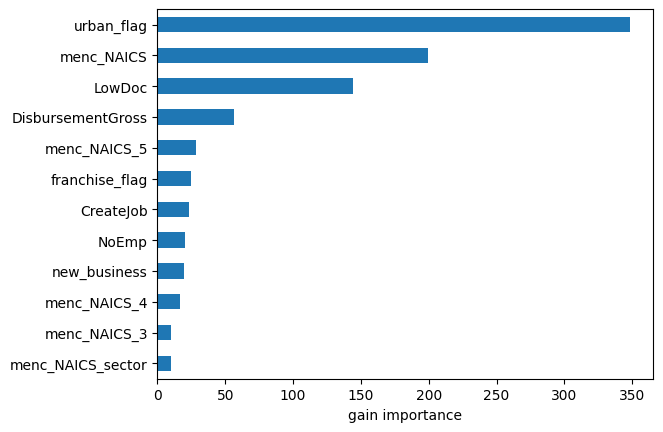

In [42]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('A22_PLOT_importance_gain.png'))

##### Permutation Importance

In [43]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [44]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [45]:
perm_importance_df.head(5)

,features,importance,abs_importance
3,DisbursementGross,0.069962,0.069962
7,menc_NAICS,0.057172,0.057172
5,urban_flag,0.035794,0.035794
1,CreateJob,0.020159,0.020159
2,LowDoc,0.014669,0.014669


In [46]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('A22_DATA_importance_perturb.csv'),
            index=False)

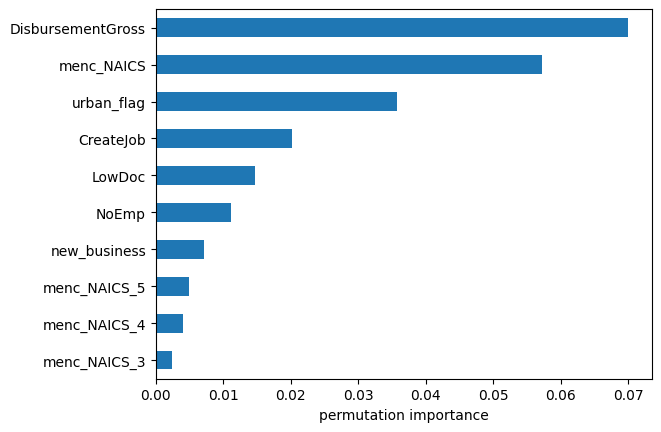

In [47]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('A22_PLOT_importance_perturb.png'))

## PDP Plot

In [48]:
feat_list = list(enc_val.columns)

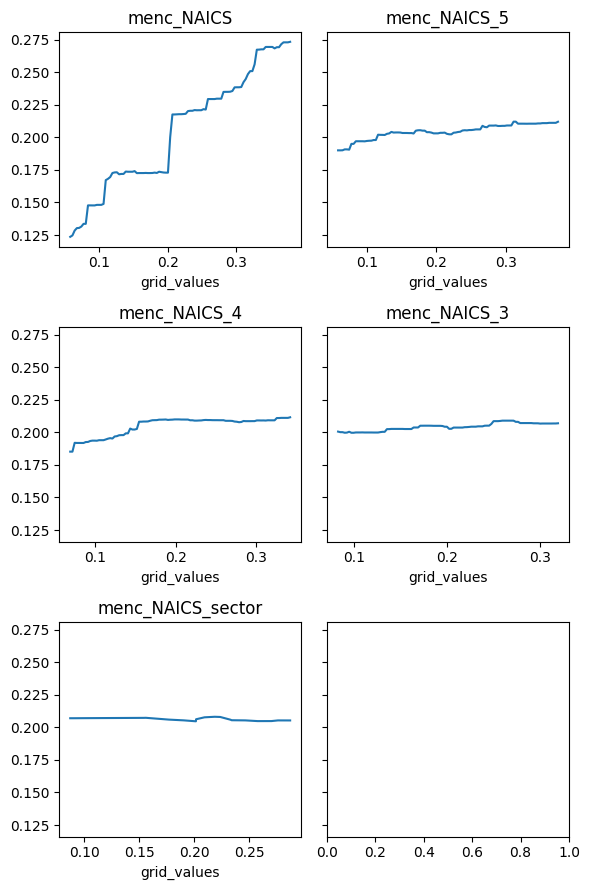

In [49]:
fig, ax = plt.subplots(int(np.ceil(len(feat_list)/2)), 2, sharex=False, 
                       sharey=True, figsize=(6, 9))
for i in range(len(feat_list)):
    col = int(i % 2)
    row = int(np.floor(i / 2))
    try:
        results = partial_dependence(xgb_model, train_df[predictor_features], 
                                     [feat_list[i]])
    except:
        continue
    pdp_df = pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})
    pdp_df.plot(x='grid_values', y='pdp', legend=None, ax=ax[row, col])
    ax[row, col].set_title(feat_list[i])

fig.tight_layout()
fig.savefig(Path(setup.temp_path).joinpath('A22_PLOT_pdp_combined.png'),
               bbox_inches='tight')
plt.show()